In [1]:
# Imported all modules I would need.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import plot_tree, export_text, DecisionTreeClassifier

In [2]:
# Obtained spanish stop words list from: https://github.com/stopwords-iso/stopwords-es/blob/master/stopwords-es.txt
# Obtained guidance on creating stop_words_list using .txt file from: https://stackoverflow.com/questions/36369870/sklearn-how-to-add-custom-stopword-list-from-txt-file#36371942
with open('../data/spanish.txt') as file:
    spanish = file.read().split()
    
with open('../data/spanish_politics.txt') as file:
    spanish_politics = file.read().split()

In [3]:
spanish[:20]

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '_',
 'a',
 'actualmente',
 'acuerdo',
 'adelante',
 'ademas',
 'además',
 'adrede',
 'afirmó',
 'agregó']

In [4]:
!python -m spacy download es_core_news_sm

     |████████████████████████████████| 12.9 MB 4.0 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [5]:
# Obtained Spanish-langauge lemmatizer function from: https://spacy.io/models/es
nlp = spacy.load("es_core_news_sm")

def lemma_tokenizer(doc):
    return [i.lemma_ for i in (nlp(doc))]

In [6]:
# Obtained Spanish-langauge stemming function from: https://stackoverflow.com/questions/26292453/how-to-stem-a-list-of-words-in-spanish-with-nltk#26294198

def stemming_tokenizer(doc):
    stemming = SnowballStemmer('spanish')
    return [stemming.stem(w) for w in word_tokenize(doc)]

In [7]:
# Set notebook's random seed to 42.
np.random.seed(42)

# **Preprocessing**

In [8]:
# Created a DataFrame from the mx_political.csv file, which contained the cleaned data.
mx_political_df = pd.read_csv('../data/mx_political.csv')

In [9]:
mx_political_df.tail()

,user,tweet
19164,PartidoMorenaMx,RT @DiputadosMorena: Abajo el patriarcado #NiU...
19165,PartidoMorenaMx,RT @DiputadosMorena: Hartas de violencias mach...
19166,PartidoMorenaMx,"RT @DiputadosMorena: Vivas, libres y en lucha ..."
19167,PartidoMorenaMx,"RT @DiputadosMorena: No nos sentimos seguras, ..."
19168,PartidoMorenaMx,RT @DiputadosMorena: Luchamos hoy para no mori...


In [10]:
# Defined my one feature, the target vector, and proceed to perform a train/test split with a random_state of 42 while stratifying on the label.
X = mx_political_df['tweet']
y = mx_political_df['user']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [11]:
# Looked at the noramlized value_counts in the target vector.
y.value_counts(normalize=True)

partidoverdemex    0.166936
PRI_Nacional       0.166884
AccionNacional     0.166832
PartidoMorenaMx    0.166780
PRDMexico          0.166519
MovCiudadanoMX     0.166049
Name: user, dtype: float64

# **Modeling**

### Baseline Model

In [13]:
# Instantiated DummyClassifier object and proceeded to fit it on the X_train and y_train before scoring both X_train/y_train and X_test/y_test.
dc = DummyClassifier()
dc.fit(X_train, y_train)
dc.score(X_train, y_train), dc.score(X_test, y_test)

(0.1669449081803005, 0.1669100771959107)

In [14]:
# Utilized the fitted DummyClassifier object to predict the target and saved the results under variable named "baseline_preds".
baseline_preds = dc.predict(X_test)

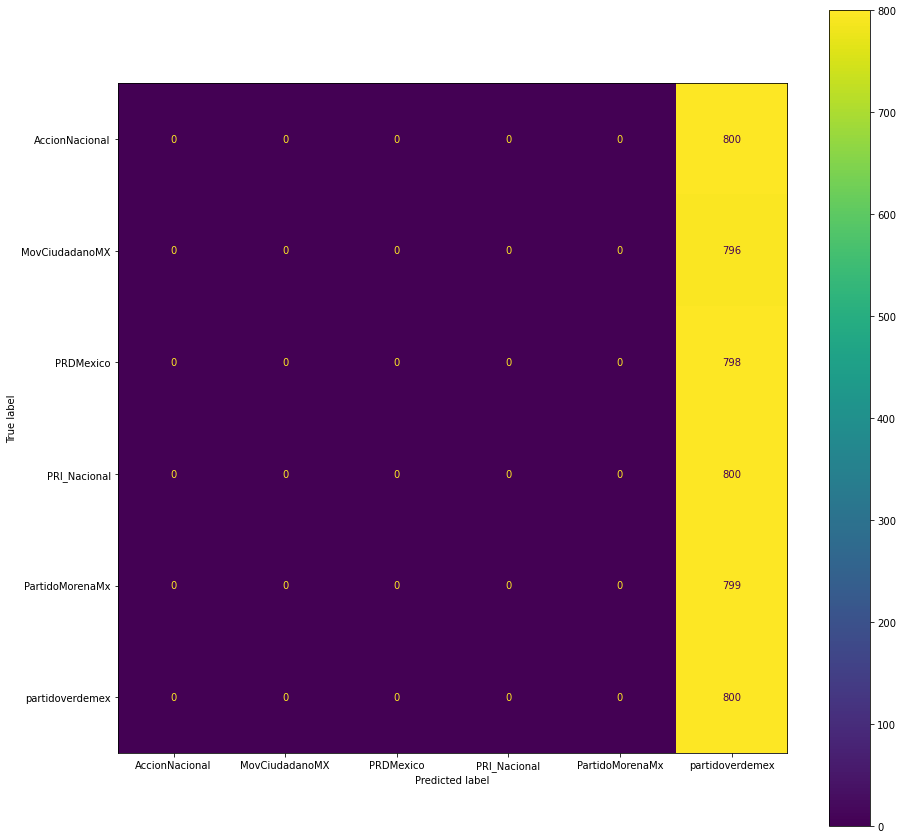

In [15]:
# Generated a ConfusionMatrixDisplay utilizing this DummyClassifier estimator.

# Obtained guidance with adjustig size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(dc, X_test, y_test, ax=ax);

In [16]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
baseline_precision = precision_score(y_test, baseline_preds, labels='PartidoMorenaMx', average='macro')
baseline_precision

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.027818346199318448

In [17]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
baseline_recall = recall_score(y_test, baseline_preds, labels='PartidoMorenaMx', average='macro')
baseline_recall

0.16666666666666666

In [18]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
baseline_f1 = f1_score(y_test, baseline_preds, labels='PartidoMorenaMx', average='macro')
baseline_f1

0.04767864592645569

## **CountVectorizer with Spanish Stop Words**

### CountVectorizer + Logistic Regression

In [69]:
# Created a pipeline object with a CountVectorizer transformer and Logistic Regression classifier with a max_iter of 10_000.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_logreg_pipe = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=10_000))
cvec_logreg_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('logisticregression', LogisticRegression(max_iter=10000))],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'logisticregression': LogisticRegression(max_iter=10000),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticre

In [70]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_logreg_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [lemma_tokenizer, stemming_tokenizer], 
    'logisticregression__C': [1.0, .1],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
    'logisticregression__solver': ['lbfgs', 'liblinear']
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [71]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_logreg_rs = RandomizedSearchCV(cvec_logreg_pipe, param_distributions=cvec_logreg_params, n_jobs=-1)

In [72]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_logreg_rs.fit(X_train, y_train)
cvec_logreg_rs.score(X_train, y_train), cvec_logreg_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['adema', 'adredir', 'afirmar', 'agregar', 'aquel él', 'asegurar', 'atra', 'añadir', 'comentar', 'considerar', 'consigu', 'contar', 'cosa', 'creer', 'cualquiera', 'deber', 'dejar', 'demá', 'despu', 'detra', 'diar', 'emplea', 'encontrar', 'erar', 'estaríai', 'estaríar', 'estuvir', 'estuviés', 'estár', 'existir', 'explicar', 'expresar', 'fuistei', 'fuérar', 'fués', 'fuésar', 'grande', 'hablar', 'habríar', 'habíai', 'hacer él', 'hayar', 'hayái', 'hora', 'hubierai', 'hubierar', 'hubir', 'hubistar', 'hubiés', 'hubiéser', 'indicar', 'informar', 'intentai', 'llegar', 'manifestar', 'mencionar', 'nosotra', 'parecer', 'podriar', 'podrio', 'quedar', 'querer', 'quizar', 'rara', 'seguir', 'sero', 'seríar', 'seái', 'señalar', 'soyo', 'tenei', 'tercero', 'todaviar', 'tratar', 'tuvir', 'tuviérir', 'tuviés

(0.9923483583750695, 0.8902566242436887)

In [39]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_logreg_rs.best_params_

{'logisticregression__solver': 'lbfgs',
 'logisticregression__penalty': 'l2',
 'logisticregression__C': 1.0,
 'countvectorizer__tokenizer': None,
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
       

In [40]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_logreg_new_params = {
    'countvectorizer__ngram_range': [(3, 3)],
    'countvectorizer__stop_words': [None, frozenset(spanish), ],
    'countvectorizer__tokenizer': [None], 
    'logisticregression__C': [1.0],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['lbfgs']
}

**Hyperparameter Tuning using GridSearch CV**

In [41]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_logreg_gs = GridSearchCV(cvec_logreg_pipe, param_grid=cvec_logreg_new_params, n_jobs=-1)

In [43]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_logreg_gs.fit(X_train, y_train)
cvec_logreg_gs.score(X_train, y_train), cvec_logreg_gs.score(X_test, y_test)

(0.9957568169170841, 0.7494262466096391)

In [44]:
# Utilized the fitted GridSearchCV object to predict the target and saved the results under variable named "cvec_logreg_gs_preds".
cvec_logreg_gs_preds = cvec_logreg_gs.predict(X_test)

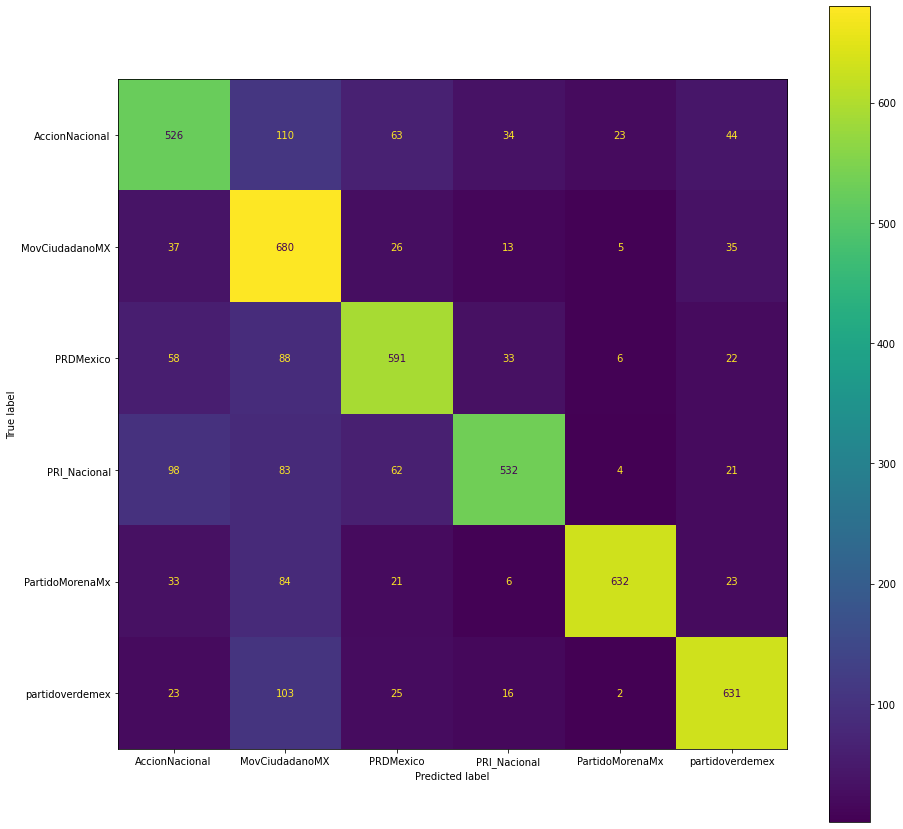

In [45]:
# Generated a ConfusionMatrixDisplay utilizing this Logistic Regression estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_logreg_gs, X_test, y_test, ax=ax);

In [46]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_logreg_gs_precision = precision_score(y_test, cvec_logreg_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_logreg_gs_precision

0.7689635686348124

In [47]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_logreg_gs_recall = recall_score(y_test, cvec_logreg_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_logreg_gs_recall

0.7495185994105363

In [48]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_logreg_gs_f1 = f1_score(y_test, cvec_logreg_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_logreg_gs_f1

0.7524695674847358

In [49]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_logreg_gs.best_params_

{'countvectorizer__ngram_range': (3, 3),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': None,
 'logisticregression__C': 1.0,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}

### CountVectorizer + KNeighborsClassifier

In [46]:
# Created a pipeline object with a CountVectorizer transformer and KNeighbors classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_knn_pipe = make_pipeline(CountVectorizer(), KNeighborsClassifier())
cvec_knn_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier

In [47]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_knn_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None, stemming],
    'kneighborsclassifier__n_neighbors': [2, 5, 10]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [48]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_knn_rs = RandomizedSearchCV(cvec_knn_pipe, param_distributions=cvec_knn_params, n_jobs=-1)

In [49]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_knn_rs.fit(X_train, y_train)
cvec_knn_rs.score(X_train, y_train), cvec_knn_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/pyt

(0.767459654980523, 0.4790319215522637)

In [50]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_knn_rs.best_params_

{'kneighborsclassifier__n_neighbors': 2,
 'countvectorizer__tokenizer': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (1, 1)}

In [51]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_knn_new_params = {
    'countvectorizer__ngram_range': [(1, 1)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None],
    'kneighborsclassifier__n_neighbors': [2, 3, 4]
}

**Hyperparameter Tuning using GridSearchCV**

In [52]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_knn_gs = GridSearchCV(cvec_knn_pipe, param_grid=cvec_knn_new_params, n_jobs=-1)

In [53]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_knn_gs.fit(X_train, y_train)
cvec_knn_gs.score(X_train, y_train), cvec_knn_gs.score(X_test, y_test)

(0.6960907067334446, 0.4773628207803046)

In [54]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_knn_gs_preds".
cvec_knn_gs_preds = cvec_knn_gs.predict(X_test)

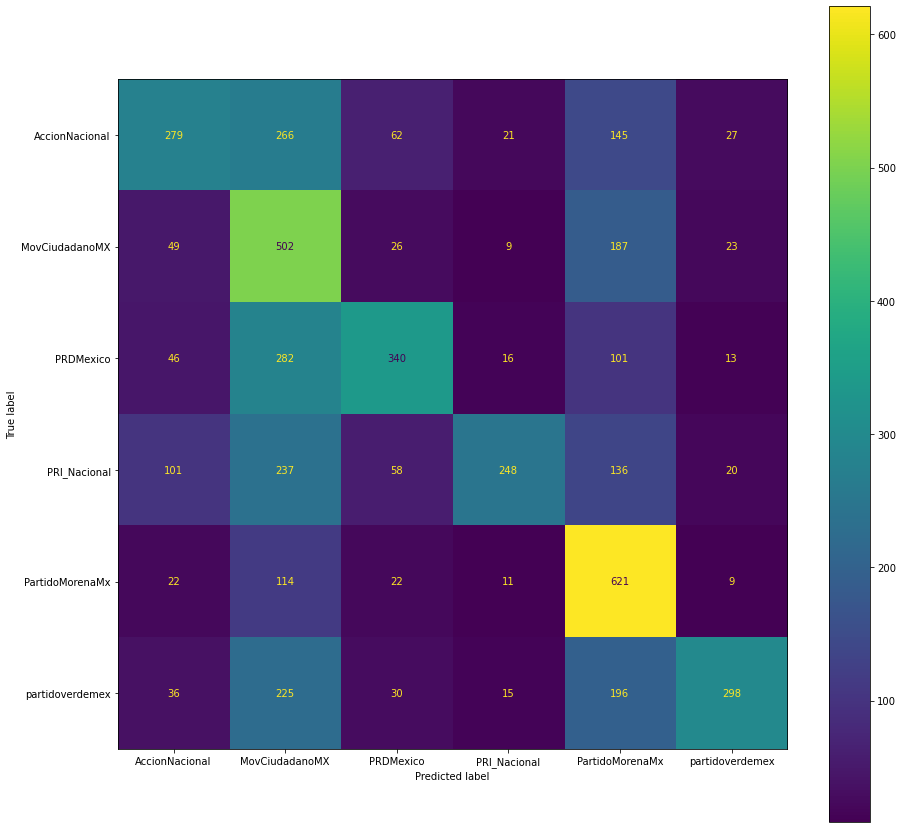

In [142]:
# Generated a ConfusionMatrixDisplay utilizing this KNeighbors Classifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_knn_gs, X_test, y_test, ax=ax);

In [56]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_knn_gs_precision = precision_score(y_test, cvec_knn_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_knn_gs_precision

0.5752183362178221

In [57]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_knn_gs_recall = recall_score(y_test, cvec_knn_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_knn_gs_recall

0.477531659357927

In [58]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_knn_gs_f1 = f1_score(y_test, cvec_knn_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_knn_gs_f1

0.47570644369154796

In [59]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_knn_gs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': None,
 'kneighborsclassifier__n_neighbors': 3}

### CountVectorizer + SVC

In [60]:
# Created a pipeline object with a CountVectorizer transformer and Support Vector Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_svc_pipe = make_pipeline(CountVectorizer(), SVC())
cvec_svc_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()), ('svc', SVC())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'svc': SVC(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 

In [62]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_svc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None, stemming],
    'svc__C': [1.0, .1]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [63]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_svc_rs = RandomizedSearchCV(cvec_svc_pipe, param_distributions=cvec_svc_params, n_jobs=-1)

In [64]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_svc_rs.fit(X_train, y_train)
cvec_svc_rs.score(X_train, y_train), cvec_svc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/pyt

(0.9846967167501391, 0.8032547465053202)

In [65]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_svc_rs.best_params_

{'svc__C': 1.0,
 'countvectorizer__tokenizer': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (2, 2)}

In [67]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_svc_new_params = {
    'countvectorizer__ngram_range': [(2, 2)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None],
    'svc__C': [1.0, .9, .8]
}

**Hyperparameter Tuning using GridSearchCV**

In [68]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_svc_gs = GridSearchCV(cvec_svc_pipe, param_grid=cvec_svc_new_params, n_jobs=-1)

In [69]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_svc_gs.fit(X_train, y_train)
cvec_svc_gs.score(X_train, y_train), cvec_svc_gs.score(X_test, y_test)

(0.9846967167501391, 0.8032547465053202)

In [70]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_svc_gs_preds".
cvec_svc_gs_preds = cvec_svc_gs.predict(X_test)

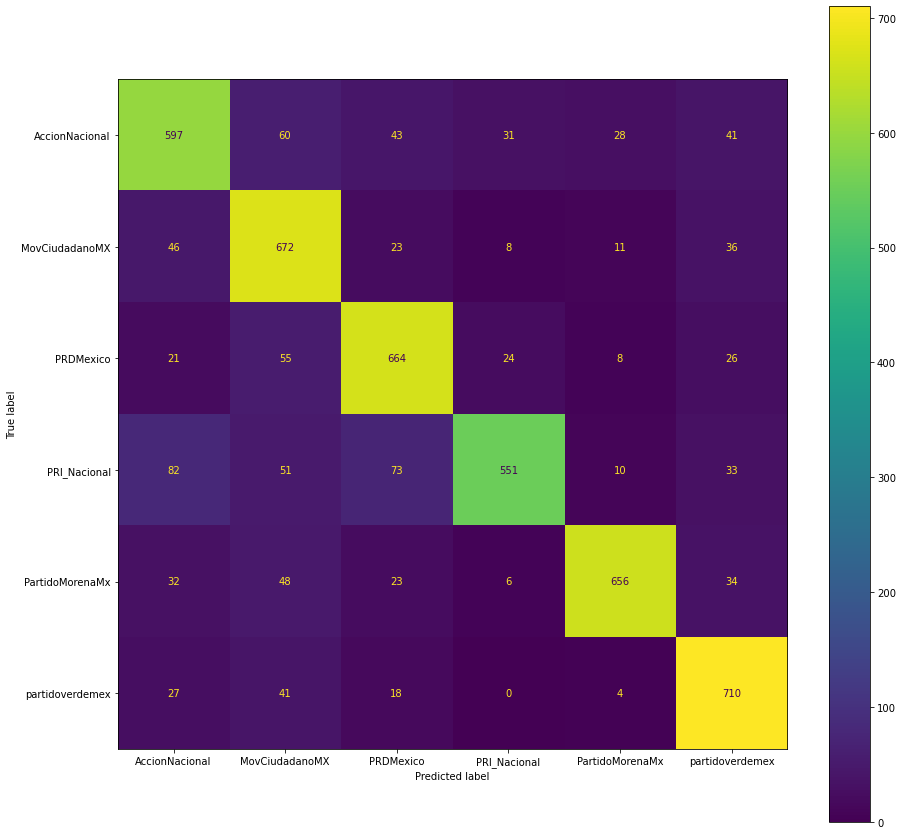

In [143]:
# Generated a ConfusionMatrixDisplay utilizing this SVC estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_svc_gs, X_test, y_test, ax=ax);

In [72]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_svc_gs_precision = precision_score(y_test, cvec_svc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_svc_gs_precision

0.8106191682055336

In [73]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_svc_gs_recall = recall_score(y_test, cvec_svc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_svc_gs_recall

0.8033045981470764

In [74]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_svc_gs_f1 = f1_score(y_test, cvec_svc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_svc_gs_f1

0.8032432731717108

In [75]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_svc_gs.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': None,
 'svc__C': 1.0}

### CountVectorizer + MultinomialNB

In [76]:
# Created a pipeline object with a CountVectorizer transformer and Multinomial Naives Bayes Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_mnb_pipe = make_pipeline(CountVectorizer(), MultinomialNB())
cvec_mnb_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('multinomialnb', MultinomialNB())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'multinomialnb': MultinomialNB(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'multinomialnb__alpha': 1.0,
 'multinomialnb__class_prior': None,
 'multinomialnb__fit_prior': True}

In [78]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_mnb_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None, stemming],
    'multinomialnb__alpha': [1.0, .5, .1]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [79]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_mnb_rs = RandomizedSearchCV(cvec_mnb_pipe, param_distributions=cvec_mnb_params, n_jobs=-1)

In [80]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_mnb_rs.fit(X_train, y_train)
cvec_mnb_rs.score(X_train, y_train), cvec_mnb_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/pyt

(0.9833055091819699, 0.874817442103067)

In [81]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_mnb_rs.best_params_

{'multinomialnb__alpha': 0.1,
 'countvectorizer__tokenizer': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (1, 1)}

In [82]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_mnb_new_params = {
    'countvectorizer__ngram_range': [(1, 1)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None],
    'multinomialnb__alpha': [0.1, 0.05, 0.01]
}

**Hyperparameter Tuning using GridSearchCV**

In [83]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_mnb_gs = GridSearchCV(cvec_mnb_pipe, param_grid=cvec_mnb_new_params, n_jobs=-1)

In [84]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_mnb_gs.fit(X_train, y_train)
cvec_mnb_gs.score(X_train, y_train), cvec_mnb_gs.score(X_test, y_test)

(0.9833055091819699, 0.874817442103067)

In [85]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_mnb_gs_preds".
cvec_mnb_gs_preds = cvec_mnb_gs.predict(X_test)

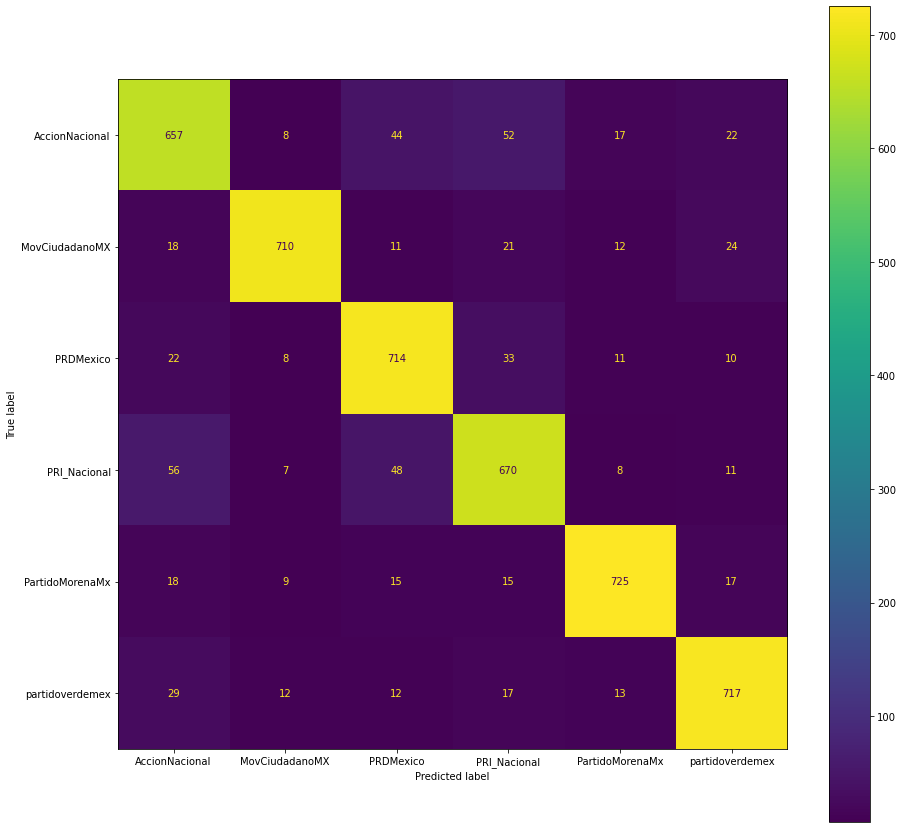

In [144]:
# Generated a ConfusionMatrixDisplay utilizing this MNB Classifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_mnb_gs, X_test, y_test, ax=ax);

In [87]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_mnb_gs_precision = precision_score(y_test, cvec_mnb_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_mnb_gs_precision

0.8759328317926705

In [88]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_mnb_gs_recall = recall_score(y_test, cvec_mnb_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_mnb_gs_recall

0.8748468118980165

In [89]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_mnb_gs_f1 = f1_score(y_test, cvec_mnb_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_mnb_gs_f1

0.8751500317346688

In [90]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_mnb_gs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': None,
 'multinomialnb__alpha': 0.1}

### CountVectorizer + DecisionTreeClassifier

In [92]:
# Created a pipeline object with a CountVectorizer transformer and Decision Tree Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_dtc_pipe = make_pipeline(CountVectorizer(), DecisionTreeClassifier())
cvec_dtc_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('decisiontreeclassifier', DecisionTreeClassifier())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'decisiontreeclassifier': DecisionTreeClassifier(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisi

In [93]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_dtc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None, stemming],
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15, 20],
    'decisiontreeclassifier__max_features': [None, 1_000, 2_000],
    'decisiontreeclassifier__min_samples_split': [None, 2, 5]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [94]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_dtc_rs = RandomizedSearchCV(cvec_dtc_pipe, param_distributions=cvec_dtc_params, n_jobs=-1)

In [95]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_dtc_rs.fit(X_train, y_train)
cvec_dtc_rs.score(X_train, y_train), cvec_dtc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/pyt

(0.9961741791875348, 0.7181306071354058)

In [96]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_dtc_rs.best_params_

{'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__max_features': 1000,
 'decisiontreeclassifier__max_depth': None,
 'countvectorizer__tokenizer': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (2, 2)}

In [97]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_dtc_new_params = {
    'countvectorizer__ngram_range': [(2,2)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None],
    'decisiontreeclassifier__max_depth': [None],
    'decisiontreeclassifier__max_features': [1000],
    'decisiontreeclassifier__min_samples_split': [2]
}

**Hyperparameter Tuning using GridSearchCV**

In [98]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_dtc_gs = GridSearchCV(cvec_dtc_pipe, param_grid=cvec_dtc_new_params, n_jobs=-1)

In [99]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_dtc_gs.fit(X_train, y_train)
cvec_dtc_gs.score(X_train, y_train), cvec_dtc_gs.score(X_test, y_test)

(0.9961741791875348, 0.6983100354683914)

In [100]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_dtc_gs_preds".
cvec_dtc_gs_preds = cvec_dtc_gs.predict(X_test)

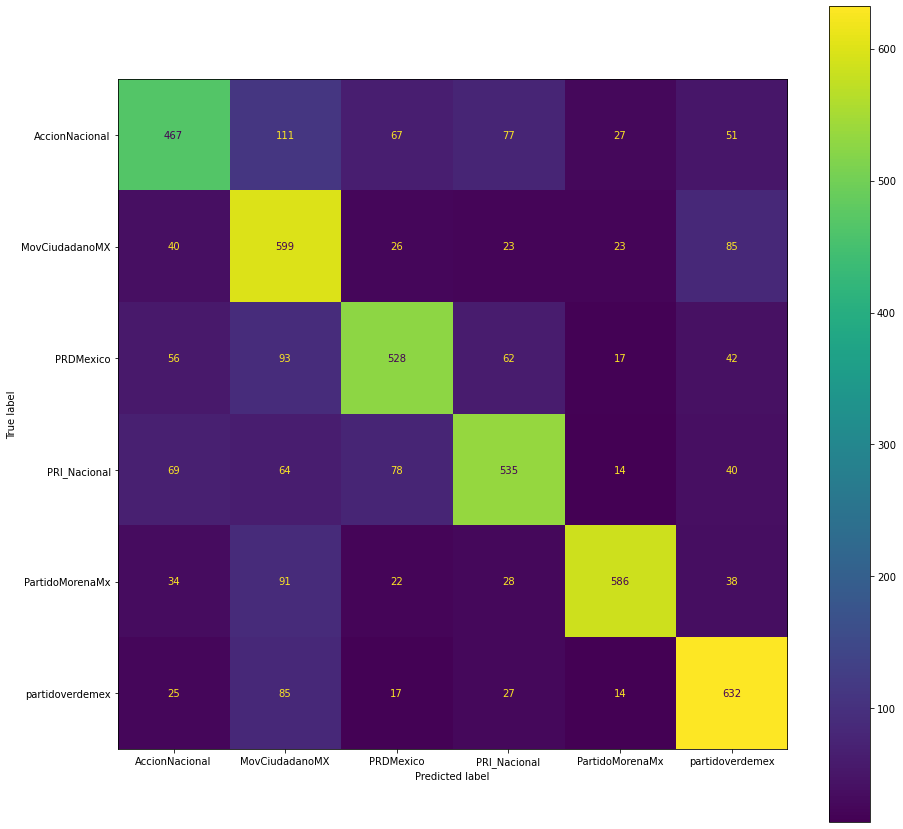

In [145]:
# Generated a ConfusionMatrixDisplay utilizing this DecisionTree Classifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_dtc_gs, X_test, y_test, ax=ax);

In [102]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_dtc_gs_precision = precision_score(y_test, cvec_dtc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_dtc_gs_precision

0.7082052198790713

In [103]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_dtc_gs_recall = recall_score(y_test, cvec_dtc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_dtc_gs_recall

0.6983472448526867

In [104]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_dtc_gs_f1 = f1_score(y_test, cvec_dtc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_dtc_gs_f1

0.6992510443296132

In [105]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_dtc_gs.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': None,
 'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__max_features': 1000,
 'decisiontreeclassifier__min_samples_split': 2}

### CountVectorizer + ExtraTreesClassifier

In [106]:
# Created a pipeline object with a CountVectorizer transformer and Extra Trees Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_etc_pipe = make_pipeline(CountVectorizer(), ExtraTreesClassifier())
cvec_etc_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('extratreesclassifier', ExtraTreesClassifier())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'extratreesclassifier': ExtraTreesClassifier(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'extratreesclassifier__bootstrap': False,
 'extratreesclassifier__ccp_alpha': 0.0,
 'extratreesclassifier

In [107]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_etc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None, stemming],
    'extratreesclassifier__max_depth': [None, 5, 10, 15, 20],
    'extratreesclassifier__max_features': [None, 1_000, 2_000],
    'extratreesclassifier__min_samples_split': [2, 3, 4],
    'extratreesclassifier__n_estimators': [100, 150, 200]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [108]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_etc_rs = RandomizedSearchCV(cvec_etc_pipe, param_distributions=cvec_etc_params, n_jobs=-1)

In [109]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_etc_rs.fit(X_train, y_train)
cvec_etc_rs.score(X_train, y_train), cvec_etc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/pyt

(0.7797718419588202, 0.7241810974337576)

In [110]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_etc_rs.best_params_

{'extratreesclassifier__n_estimators': 150,
 'extratreesclassifier__min_samples_split': 3,
 'extratreesclassifier__max_features': 1000,
 'extratreesclassifier__max_depth': 20,
 'countvectorizer__tokenizer': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (2, 2)}

In [112]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_etc_new_params = {
    'countvectorizer__ngram_range': [(2,2)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None],
    'extratreesclassifier__max_depth': [20],
    'extratreesclassifier__max_features': [1000],
    'extratreesclassifier__min_samples_split': [3],
    'extratreesclassifier__n_estimators': [150]
}

**Hyperparameter Tuning using GridSearchCV**

In [113]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_etc_gs = GridSearchCV(cvec_etc_pipe, param_grid=cvec_etc_new_params, n_jobs=-1)

In [114]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_etc_gs.fit(X_train, y_train)
cvec_etc_gs.score(X_train, y_train), cvec_etc_gs.score(X_test, y_test)

(0.7867278797996661, 0.7306488629250991)

In [115]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_etc_gs_preds".
cvec_etc_gs_preds = cvec_etc_gs.predict(X_test)

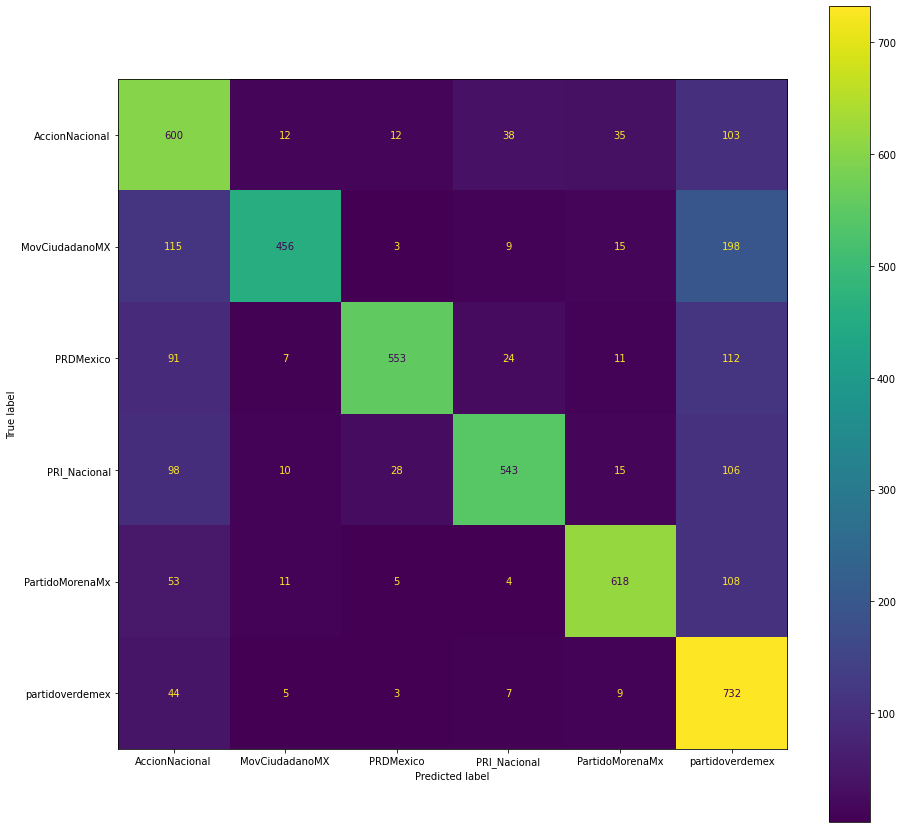

In [146]:
# Generated a ConfusionMatrixDisplay utilizing this ExtraTreesClassifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_etc_gs, X_test, y_test, ax=ax);

In [117]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_etc_gs_precision = precision_score(y_test, cvec_etc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_etc_gs_precision

0.7852773527560891

In [118]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_etc_gs_recall = recall_score(y_test, cvec_etc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_etc_gs_recall

0.7305106018817198

In [119]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_etc_gs_f1 = f1_score(y_test, cvec_etc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_etc_gs_f1

0.7369050750181217

In [120]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_etc_gs.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': None,
 'extratreesclassifier__max_depth': 20,
 'extratreesclassifier__max_features': 1000,
 'extratreesclassifier__min_samples_split': 3,
 'extratreesclassifier__n_estimators': 150}

### CountVectorizer + RandomForestClassifier

In [121]:
# Created a pipeline object with a CountVectorizer transformer and Random Forest Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_rfc_pipe = make_pipeline(CountVectorizer(), RandomForestClassifier())
cvec_rfc_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'randomforestclassifier': RandomForestClassifier(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomfor

In [122]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_rfc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None, stemming],
    'randomforestclassifier__max_depth': [None, 5, 10, 15, 20],
    'randomforestclassifier__max_features': [None, 1_000, 2_000],
    'randomforestclassifier__min_samples_split': [2, 3, 4],
    'randomforestclassifier__n_estimators': [100, 150, 200]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [123]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_rfc_rs = RandomizedSearchCV(cvec_rfc_pipe, param_distributions=cvec_rfc_params, n_jobs=-1)

In [124]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_rfc_rs.fit(X_train, y_train)
cvec_rfc_rs.score(X_train, y_train), cvec_rfc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/pyt

(0.741652754590985, 0.7120801168370541)

In [125]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_rfc_rs.best_params_

{'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__max_features': 1000,
 'randomforestclassifier__max_depth': 15,
 'countvectorizer__tokenizer': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (1, 1)}

In [126]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_rfc_new_params = {
    'countvectorizer__ngram_range': [(1, 1)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None],
    'randomforestclassifier__max_depth': [15],
    'randomforestclassifier__max_features': [1000],
    'randomforestclassifier__min_samples_split': [4],
    'randomforestclassifier__n_estimators': [100]
}

**Hyperparameter Tuning using GridSearchCV**

In [128]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_rfc_gs = GridSearchCV(cvec_rfc_pipe, param_grid=cvec_rfc_new_params, n_jobs=-1)

In [147]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_rfc_gs.fit(X_train, y_train)
cvec_rfc_gs.score(X_train, y_train), cvec_rfc_gs.score(X_test, y_test)

(0.7308708959376738, 0.7026914249947841)

In [148]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_rfc_gs_preds".
cvec_rfc_gs_preds = cvec_rfc_gs.predict(X_test)

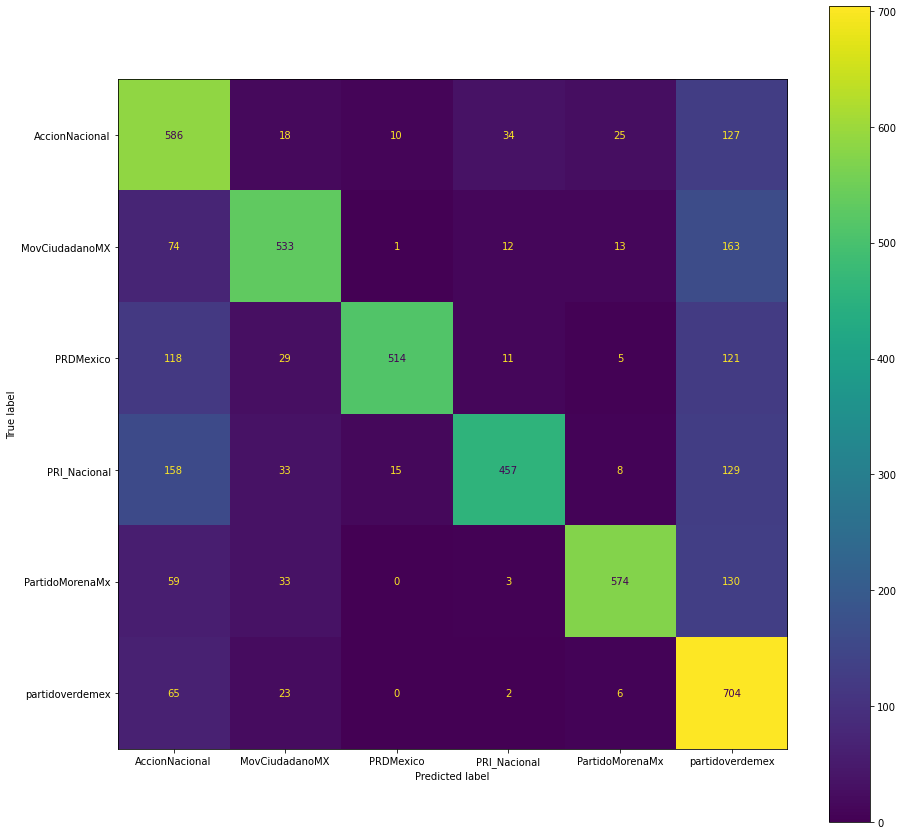

In [149]:
# Generated a ConfusionMatrixDisplay utilizing this RandomForestClassifier estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_rfc_gs, X_test, y_test, ax=ax);

In [151]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_rfc_gs_precision = precision_score(y_test, cvec_rfc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_rfc_gs_precision

0.7673288131426269

In [152]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_rfc_gs_recall = recall_score(y_test, cvec_rfc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_rfc_gs_recall

0.7026427105226406

In [153]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_rfc_gs_f1 = f1_score(y_test, cvec_rfc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_rfc_gs_f1

0.7115773317434598

In [154]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_rfc_gs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': None,
 'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__max_features': 1000,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__n_estimators': 100}

### CountVectorizer + GradientBoostingClassifier

In [155]:
# Created a pipeline object with a CountVectorizer transformer and Gradient Boosting Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_gbc_pipe = make_pipeline(CountVectorizer(), GradientBoostingClassifier())
cvec_gbc_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('gradientboostingclassifier', GradientBoostingClassifier())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'gradientboostingclassifier': GradientBoostingClassifier(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'gradientboostingclassifier__ccp_alpha': 0.0,
 'gradientboostingclassifier__crite

In [204]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_gbc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None, frozenset(spanish)],
    'countvectorizer__tokenizer': [None, stemming_tokenizer],
    'gradientboostingclassifier__max_depth': [None, 5, 10, 15, 20],
    'gradientboostingclassifier__max_features': [None, 1_000, 2_000],
    'gradientboostingclassifier__min_samples_split': [2, 3, 4],
    'gradientboostingclassifier__n_estimators': [100, 150, 200]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [205]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_gbc_rs = RandomizedSearchCV(cvec_gbc_pipe, param_distributions=cvec_gbc_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_gbc_rs.fit(X_train, y_train)
cvec_gbc_rs.score(X_train, y_train), cvec_gbc_rs.score(X_test, y_test)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_gbc_rs.best_params_

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_gbc_new_params = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [lemma_tokenizer],
    'gradientboostingclassifier__max_depth': [10],
    'gradientboostingclassifier__max_features': [1_000],
    'gradientboostingclassifier__min_samples_split': [3],
    'gradientboostingclassifier__n_estimators': [100]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_gbc_gs = GridSearchCV(cvec_gbc_pipe, param_grid=cvec_gbc_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_gbc_gs.fit(X_train, y_train)
cvec_gbc_gs.score(X_train, y_train), cvec_gbc_gs.score(X_test, y_test)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_gbc_gs_preds".
cvec_gbc_gs_preds = cvec_gbc_gs.predict(X_test)

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this GradientBoostingClassifier estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_gbc_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_gbc_gs_precision = precision_score(y_test, cvec_gbc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_gbc_gs_precision

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_gbc_gs_recall = recall_score(y_test, cvec_gbc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_gbc_gs_recall

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_gbc_gs_f1 = f1_score(y_test, cvec_gbc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_gbc_gs_f1

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_gbc_gs.best_params_

## **CountVectorizer with Spanish + Party and Politican Stop Words**

### CountVectorizer + Logistic Regression

In [19]:
# Created a pipeline object with a CountVectorizer transformer and Logistic Regression classifier with a max_iter of 10_000.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_logreg_pipe = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=10_000))
cvec_logreg_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('logisticregression', LogisticRegression(max_iter=10000))],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'logisticregression': LogisticRegression(max_iter=10000),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticre

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_logreg_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [lemma_tokenizer, stemming_tokenizer], 
    'logisticregression__C': [1.0, .1],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
    'logisticregression__solver': ['lbfgs', 'liblinear']
}

## **TfidfVectorizer**

### TfidfVectorizer + Logistic Regression

In [ ]:
# Created a pipeline object with a TfidfVectorizer transformer and Logistic Regression classifier with a max_iter of 10_000.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_logreg_pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=10_000))
tfidf_logreg_pipe.get_params()

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_logreg_params = {
    'tfidfvectorizer__max_df': [.9, .8],
    'tfidfvectorizer__min_df': [.1, .2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, frozenset(spanish)],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'logisticregression__C': [1.0, .1],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
    'logisticregression__solver': ['lbfgs', 'liblinear']
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_logreg_rs = RandomizedSearchCV(tfidf_logreg_pipe, param_distributions=tfidf_logreg_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_logreg_rs.fit(X_train, y_train)
tfidf_logreg_rs.score(X_train, y_train), tfidf_logreg_rs.score(X_test, y_test)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_logreg_rs.best_params_

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_logreg_new_params = {
    'tfidfvectorizer__max_df': [.9],
    'tfidfvectorizer__min_df': [.2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': [None],
    'tfidfvectorizer__tokenizer': [None],
    'logisticregression__C': [.1, .2, .3],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['lbfgs']
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_logreg_gs = GridSearchCV(tfidf_logreg_pipe, param_grid=tfidf_logreg_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_logreg_gs.fit(X_train, y_train)
tfidf_logreg_gs.score(X_train, y_train), tfidf_logreg_gs.score(X_test, y_test)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_logreg_gs_preds".
tfidf_logreg_gs_preds = tfidf_logreg_gs.predict(X_test)

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this Logistic Regression estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(tfidf_logreg_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
tfidf_logreg_gs_precision = precision_score(y_test, tfidf_logreg_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_logreg_gs_precision

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
tfidf_logreg_gs_recall = recall_score(y_test, tfidf_logreg_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_logreg_gs_recall

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
tfidf_logreg_gs_f1 = f1_score(y_test, tfidf_logreg_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_logreg_gs_f1

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_logreg_gs.best_params_

### TfidfVectorizer + KNeighborsClassifier

In [ ]:
# Created a pipeline object with a TfidfVectorizer transformer and KNeighbors Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_knn_pipe = make_pipeline(TfidfVectorizer(), KNeighborsClassifier())
tfidf_knn_pipe.get_params()

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_knn_params = {
    'tfidfvectorizer__max_df': [.9, .8, .7],
    'tfidfvectorizer__min_df': [.1, .3, .5], 
    'tfidfvectorizer__ngram_range': [(1,1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'kneighborsclassifier__n_neighbors': [2, 5, 10]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_knn_rs = RandomizedSearchCV(tfidf_knn_pipe, param_distributions=tfidf_knn_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_knn_rs.fit(X_train, y_train)
tfidf_knn_rs.score(X_train, y_train), tfidf_knn_rs.score(X_test, y_test)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_knn_rs.best_params_

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_knn_new_params = {
    'tfidfvectorizer__max_df': [.7],
    'tfidfvectorizer__min_df': [.1], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': ['english'],
    'tfidfvectorizer__tokenizer': [stemming_tokenizer],
    'kneighborsclassifier__n_neighbors': [2, 3, 4]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_knn_gs = GridSearchCV(tfidf_knn_pipe, param_grid=tfidf_knn_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_knn_gs.fit(X_train, y_train)
tfidf_knn_gs.score(X_train, y_train), tfidf_knn_gs.score(X_test, y_test)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_knn_gs_preds".
tfidf_knn_gs_preds = tfidf_knn_gs.predict(X_test)

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this KNeighborsClassifier estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(tfidf_knn_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
tfidf_knn_gs_precision = precision_score(y_test, tfidf_knn_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_knn_gs_precision

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
tfidf_knn_gs_recall = recall_score(y_test, tfidf_knn_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_knn_gs_recall

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
tfidf_knn_gs_f1 = f1_score(y_test, tfidf_knn_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_knn_gs_f1

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_knn_gs.best_params_

### TfidfVectorizer + SVC

In [ ]:
# Created a pipeline object with a TfidfVectorizer transformer and Support Vector Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_svc_pipe = make_pipeline(TfidfVectorizer(), SVC())
tfidf_svc_pipe.get_params()

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_svc_params = {
    'tfidfvectorizer__max_df': [.9, .8, .7],
    'tfidfvectorizer__min_df': [.1, .3, .5], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'svc__C': [1.0, .1]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_svc_rs = RandomizedSearchCV(tfidf_svc_pipe, param_distributions=tfidf_svc_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_svc_rs.fit(X_train, y_train)
tfidf_svc_rs.score(X_train, y_train), tfidf_svc_rs.score(X_test, y_test)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_svc_rs.best_params_

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_svc_new_params = {
    'tfidfvectorizer__max_df': [.7, .8, .9],
    'tfidfvectorizer__min_df': [.1, .2, .3], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': ['english'],
    'tfidfvectorizer__tokenizer': [None],
    'svc__C': [.1, .2, .3]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_svc_gs = GridSearchCV(tfidf_svc_pipe, param_grid=tfidf_svc_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_svc_gs.fit(X_train, y_train)
tfidf_svc_gs.score(X_train, y_train), tfidf_svc_gs.score(X_test, y_test)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_svc_gs_preds".
tfidf_svc_gs_preds = tfidf_svc_gs.predict(X_test)

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this SVC estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(tfidf_svc_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
tfidf_svc_gs_precision = precision_score(y_test, tfidf_svc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_svc_gs_precision

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
tfidf_svc_gs_recall = recall_score(y_test, tfidf_svc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_svc_gs_recall

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
tfidf_svc_gs_f1 = f1_score(y_test, tfidf_svc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_svc_gs_f1

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_svc_gs.best_params_

### TfidfVectorizer + GaussianNB

In [ ]:
# Instantiated an object of the GaussianNB class.
tfidf_gnb = GaussianNB()

In [ ]:
# Fit the GaussianNB object on the array version of the TFIDF-vectorized titles (X_train) and y_train before scoring on both the X_train array/y_train and X_test array/y_test. 
tfidf_gnb.fit(X_train_tfidf_vec.A, y_train)
tfidf_gnb.score(X_train_tfidf_vec.A, y_train), tfidf_gnb.score(X_test_tfidf_vec.A, y_test)

In [ ]:
# Utilized the fitted GaussianNB object to predict the target and saved the results under variable named "tfidf_gnb_preds".
tfidf_gnb_preds = tfidf_gnb.predict(X_test_tfidf_vec.A)

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this GaussianNB estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(tfidf_gnb, X_test_tfidf_vec.A, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
tfidf_gnb_precision = precision_score(y_test, tfidf_gnb_preds, labels='PartidoMorenaMx', average='macro')
tfidf_gnb_precision

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
tfidf_gnb_recall = recall_score(y_test, tfidf_gnb_preds, labels='PartidoMorenaMx', average='macro')
tfidf_gnb_recall

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
tfidf_gnb_f1 = f1_score(y_test, tfidf_gnb_preds, labels='PartidoMorenaMx', average='macro')
tfidf_gnb_f1

### TfidfVectorizer + DecisionTreeClassifier

In [ ]:
# Created a pipeline object with a TfidfVectorizer transformer and Decision Tree Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_dtc_pipe = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())
tfidf_dtc_pipe.get_params()

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_dtc_params = {
    'tfidfvectorizer__max_df': [.9, .8],
    'tfidfvectorizer__min_df': [.1, .2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15, 20],
    'decisiontreeclassifier__max_features': [None, 1_000, 2_000],
    'decisiontreeclassifier__min_samples_split': [None, 2, 5]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_dtc_rs = RandomizedSearchCV(tfidf_dtc_pipe, param_distributions=tfidf_dtc_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_dtc_rs.fit(X_train, y_train)
tfidf_dtc_rs.score(X_train, y_train), tfidf_dtc_rs.score(X_test, y_test)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_dtc_rs.best_params_

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_dtc_new_params = {
    'tfidfvectorizer__max_df': [.9],
    'tfidfvectorizer__min_df': [.1], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': ['english'],
    'tfidfvectorizer__tokenizer': [None],
    'decisiontreeclassifier__max_depth': [5],
    'decisiontreeclassifier__max_features': [None],
    'decisiontreeclassifier__min_samples_split': [2, 3, 4]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_dtc_gs = GridSearchCV(tfidf_dtc_pipe, param_grid=tfidf_dtc_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_dtc_gs.fit(X_train, y_train)
tfidf_dtc_gs.score(X_train, y_train), tfidf_dtc_gs.score(X_test, y_test)

In [ ]:
# Utilized the fitted DecisionTreeClassifier object to predict the target and saved the results under variable named "baseline_preds".
tfidf_dtc_gs_preds = tfidf_dtc_gs.predict(X_test)

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this DecisionTreeClassifier estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(tfidf_dtc_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
tfidf_dtc_gs_precision = precision_score(y_test, tfidf_dtc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_dtc_gs_precision

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
tfidf_dtc_gs_recall = recall_score(y_test, tfidf_dtc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_dtc_gs_recall

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
tfidf_dtc_gs_f1 = f1_score(y_test, tfidf_dtc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_dtc_gs_f1

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_dtc_gs.best_params_

### TfidfVectorizer + ExtraTreesClassifier

In [ ]:
# Created a pipeline object with a TfidfVectorizer transformer and Extra Trees Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_etc_pipe = make_pipeline(TfidfVectorizer(), ExtraTreesClassifier())
tfidf_etc_pipe.get_params()

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_etc_params = {
    'tfidfvectorizer__max_df': [.9, .8],
    'tfidfvectorizer__min_df': [.1, .2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'extratreesclassifier__max_depth': [None, 5, 10, 15, 20],
    'extratreesclassifier__max_features': [None, 1_000, 2_000],
    'extratreesclassifier__min_samples_split': [None, 2, 5]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_etc_rs = RandomizedSearchCV(tfidf_etc_pipe, param_distributions=tfidf_etc_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_etc_rs.fit(X_train, y_train)
tfidf_etc_rs.score(X_train, y_train), tfidf_etc_rs.score(X_test, y_test)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_etc_rs.best_params_

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_etc_new_params = {
    'tfidfvectorizer__max_df': [.8],
    'tfidfvectorizer__min_df': [.1], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': [None],
    'tfidfvectorizer__tokenizer': [stemming_tokenizer],
    'extratreesclassifier__max_depth': [20],
    'extratreesclassifier__max_features': [None],
    'extratreesclassifier__min_samples_split': [2, 3, 4]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_etc_gs = GridSearchCV(tfidf_etc_pipe, param_grid=tfidf_etc_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_etc_gs.fit(X_train, y_train)
tfidf_etc_gs.score(X_train, y_train), tfidf_etc_gs.score(X_test, y_test)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_etc_gs_preds".
tfidf_etc_gs_preds = tfidf_etc_gs.predict(X_test)

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this ExtraTreesClassifier estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(tfidf_etc_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
tfidf_etc_gs_precision = precision_score(y_test, tfidf_etc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_etc_gs_precision

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
tfidf_etc_gs_recall = recall_score(y_test, tfidf_etc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_etc_gs_recall

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
tfidf_etc_gs_f1 = f1_score(y_test, tfidf_etc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_etc_gs_f1

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_etc_gs.best_params_

### TfidfVectorizer + RandomForestClassifier

In [ ]:
# Created a pipeline object with a TfidfVectorizer transformer and Random Forest Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_rfc_pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
tfidf_rfc_pipe.get_params()

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_rfc_params = {
    'tfidfvectorizer__max_df': [.9, .8],
    'tfidfvectorizer__min_df': [.1, .2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'randomforestclassifier__max_depth': [None, 5, 10, 15, 20],
    'randomforestclassifier__max_features': [None, 1_000, 2_000],
    'randomforestclassifier__min_samples_split': [None, 2, 5]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_rfc_rs = RandomizedSearchCV(tfidf_rfc_pipe, param_distributions=tfidf_rfc_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_rfc_rs.fit(X_train, y_train)
tfidf_rfc_rs.score(X_train, y_train), tfidf_rfc_rs.score(X_test, y_test)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_rfc_rs.best_params_

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_rfc_new_params = {
    'tfidfvectorizer__max_df': [.9],
    'tfidfvectorizer__min_df': [.1], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': ['english'],
    'tfidfvectorizer__tokenizer': [stemming_tokenizer],
    'randomforestclassifier__max_depth': [15],
    'randomforestclassifier__max_features': [None],
    'randomforestclassifier__min_samples_split': [2, 3, 4]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_rfc_gs = GridSearchCV(tfidf_rfc_pipe, param_grid=tfidf_rfc_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_rfc_gs.fit(X_train, y_train)
tfidf_rfc_gs.score(X_train, y_train), tfidf_rfc_gs.score(X_test, y_test)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_rfc_gs_preds".
tfidf_rfc_gs_preds = tfidf_rfc_gs.predict(X_test)

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this RandomForestClassifier estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(tfidf_rfc_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
tfidf_rfc_gs_precision = precision_score(y_test, tfidf_rfc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_rfc_gs_precision

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
tfidf_rfc_gs_recall = recall_score(y_test, tfidf_rfc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_rfc_gs_recall

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
tfidf_rfc_gs_f1 = f1_score(y_test, tfidf_rfc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_rfc_gs_f1

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_rfc_gs.best_params_

### TfidfVectorizer + GradientBoostingClassifier

In [ ]:
# Created a pipeline object with a TfidfVectorizer transformer and Gradient Boosting Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_gbc_pipe = make_pipeline(TfidfVectorizer(), GradientBoostingClassifier())
tfidf_gbc_pipe.get_params()

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_gbc_params = {
    'tfidfvectorizer__max_df': [.9, .8],
    'tfidfvectorizer__min_df': [.1, .2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'gradientboostingclassifier__max_depth': [None, 5, 10, 15, 20],
    'gradientboostingclassifier__max_features': [None, 1_000, 2_000],
    'gradientboostingclassifier__min_samples_split': [2, 3, 4],
    'gradientboostingclassifier__n_estimators': [100, 150, 200]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_gbc_rs = RandomizedSearchCV(tfidf_gbc_pipe, param_distributions=tfidf_gbc_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_gbc_rs.fit(X_train, y_train)
tfidf_gbc_rs.score(X_train, y_train), tfidf_gbc_rs.score(X_test, y_test)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_gbc_rs.best_params_

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_gbc_new_params = {
    'tfidfvectorizer__max_df': [.9],
    'tfidfvectorizer__min_df': [.2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': [None],
    'tfidfvectorizer__tokenizer': [lemma_tokenizer],
    'gradientboostingclassifier__max_depth': [None],
    'gradientboostingclassifier__max_features': [None],
    'gradientboostingclassifier__min_samples_split': [2],
    'gradientboostingclassifier__n_estimators': [100]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_gbc_gs = GridSearchCV(tfidf_gbc_pipe, param_grid=tfidf_gbc_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_gbc_gs.fit(X_train, y_train)
tfidf_gbc_gs.score(X_train, y_train), tfidf_gbc_gs.score(X_test, y_test)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_gbc_gs_preds".
tfidf_gbc_gs_preds = tfidf_gbc_gs.predict(X_test)

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this GradientBoostingClassifier estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(tfidf_gbc_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
tfidf_gbc_gs_precision = precision_score(y_test, tfidf_gbc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_gbc_gs_precision

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
tfidf_gbc_gs_recall = recall_score(y_test, tfidf_gbc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_gbc_gs_recall

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
tfidf_gbc_gs_f1 = f1_score(y_test, tfidf_gbc_gs_preds, labels='PartidoMorenaMx', average='macro')
tfidf_gbc_gs_f1

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_gbc_gs.best_params_

## **TfidfVectorizer with Party and Politican Names Stop Words**

## **spaCy**

# **Evaluation of Best Model:**